## Processing EB imaging data
Note that here we use a max projection across z-planes instead of analyzing 4D imaging data.

In [1]:
from ScanImageTiffReader import ScanImageTiffReader
import json
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as ppatch
import numpy as np

#from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import napari

import xarray as xr

#for roi generation
import shapely as sp
from shapely.geometry.polygon import LinearRing, Polygon, LineString

%gui qt5
%config Completer.use_jedi = False  #magic to fix autocomplete issue

In [2]:
from fly2p.viz.viz import myAxisTheme
import fly2p.preproc.imgPreproc as imp
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict, loadvolume

#### Set paths to data files and plot directory

In [3]:
dataDir = '../../../../data/EPG/SS96_x_7f/f01'
rawTiff = 'SS96-x-7f_f01_3-5d_EB_2LM_00001.tif'
plotDir = sep.join([sep.join(dataDir.split(sep)[0:-2]), 'plot'])

print(dataDir)
print(plotDir)

genotype = rawTiff.split('_')[0]
[flyID, age, region] = rawTiff.split('_')[1:4]
condition = rawTiff.split('_')[-2]
trial = rawTiff.split('_')[-1][:-4]
print(genotype, region, flyID, age, condition, trial)



../../../../data/EPG/SS96_x_7f/f01
../../../../data/EPG/plot
SS96-x-7f EB f01 3-5d 2LM 00001


In [4]:
# Generate directory where to save plots
saveDir = sep.join([plotDir,genotype, condition])
if not exists(saveDir):
    makedirs(saveDir)
print(saveDir)

../../../../data/EPG/plot/SS96-x-7f/2LM


#### Load data and perform motion correction

In [5]:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))
basicMetadat = getSIbasicMetadata(mytiffreader.metadata())
basicMetadat["CaCh"] = 0 # give channel identity
SImetadict = getSIMetadict(mytiffreader.metadata())
#basicMetadat

SI.VERSION_COMMIT = '4a9264c4fccd21a03258704d0d6489537ad79e6c'
SI.VERSION_MAJOR = '2018b'
SI.VERSION_MINOR = '1'


{'nCh': 1,
 'fpsscan': 38.1043,
 'discardFBFrames': 'false',
 'nDiscardFBFrames': 0,
 'fpv': 7,
 'nVols': 1400,
 'stackZStepSize': 9,
 'scanVolumeRate': 5.44347,
 'fovCoords': [array([-25.3125, -25.3125]),
  array([25.3125, 25.3125]),
  array([ 25.3125, -25.3125]),
  array([-25.3125,  25.3125])],
 'xrange_um': 50.625,
 'yrange_um': 50.625,
 'CaCh': 0}

In [6]:
stack = loadvolume(mytiffreader, basicMetadat, selectCaChan=True)
imgStack = imp.stack2xarray(stack, basicMetadat)

Check if reference image is good: It should not be to biased by transient activity peaks.

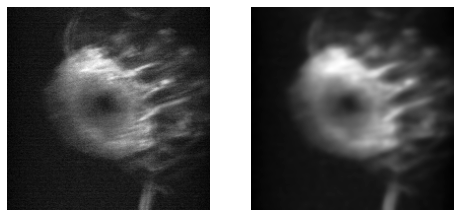

In [7]:
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over volume

numRefImg = 600
locRefImg = round(stackMP['volumes [s]'].size/3)

# Generate reference image
refImg = np.mean(stackMP[locRefImg:locRefImg+numRefImg,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower'); axs[1].axis('off');

In [8]:
stackMPMC, shift = imp.motionCorrection(stackMP, refImg, 20, 2)

#### Compute DFF

In [9]:
## Settings
# settings for Savitzky-Golay filter (default: 3rd order, 7 frames)
order = 3
window = 7

# Currently F_0 is estimated for each pixel on the whole time series (ok, if time series is short)
baseLinePercent = 10
offset = 0.0001

In [10]:
dffStack, stackF0 = imp.computeDFF(stackMPMC, order, window, baseLinePercent, offset)

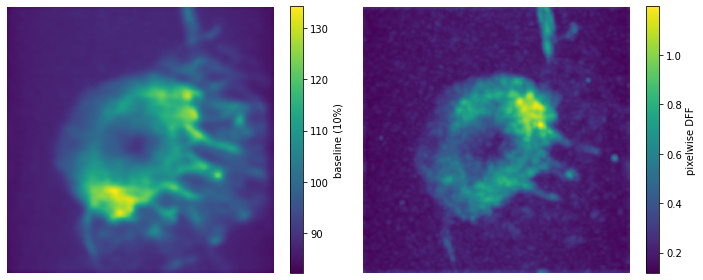

In [11]:
dffMP = np.max(dffStack,axis=0)

fig, ax = plt.subplots(1,2,figsize=(10,4))
cb = ax[0].imshow(stackF0,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[0], label='baseline ({}%)'.format(baseLinePercent))
ax[0].axis('off')
cb = ax[1].imshow(dffMP,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[1], label='pixelwise DFF')
ax[1].axis('off')
fig.tight_layout()
#viewerdff = napari.view_image(dffStackMC)

In [28]:
viewer = napari.view_image(refImgFilt)

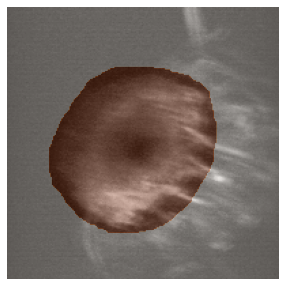

In [33]:
# you can draw a mask:
mask = viewer.layers["mask"]
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(refImg,cmap='Greys_r',origin='upper')
ax.axis('off');
ax.imshow(mask.data, cmap='Oranges', alpha=0.35)
fig.savefig(saveDir+sep+'_'.join(['mask',genotype, region, flyID, age, condition, trial])+'.pdf')

Generate ROIs automatically

In [34]:
# Settings
from sklearn.cluster import KMeans

nclst = 9 # 8 + 1 or 2

toClust = dffStack[:,mask.data>0]

kmeans = KMeans(n_clusters=nclst)
kmeans.fit(toClust.T)

kmlabs = kmeans.predict(toClust.T)
centroids = kmeans.cluster_centers_

In [35]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = np.linspace(0, stackMPMC.shape[0]/basicMetadat['fpv'], stackMPMC.shape[0])

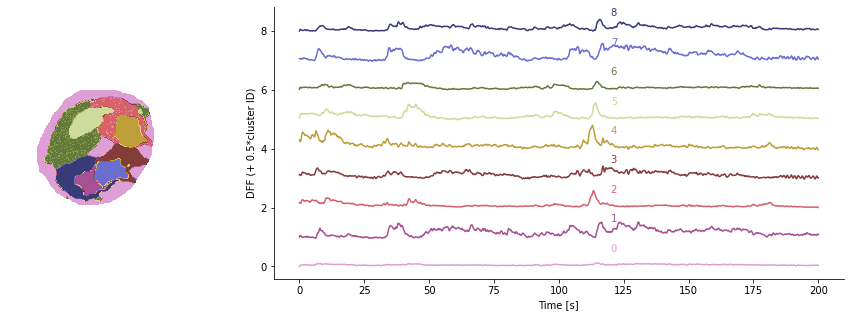

In [36]:
kmlabsImg = np.nan*np.ones(mask.data.shape)

kmlabsImg[mask.data>0] = kmlabs

fig, axs = plt.subplots(1,2,figsize=(15,5), gridspec_kw={'width_ratios':[1,3]})

axs[0].imshow(kmlabsImg,cmap=myClstMap,origin='upper')
axs[0].axis('off')

for i in range(nclst):
    axs[1].plot(time,centroids[i]+i, color=clstCMap.to_rgba(i+1))
    axs[1].text(120,+i+.5,str(i),color=clstCMap.to_rgba(i+1))
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('DFF (+ 0.5*cluster ID)')
myAxisTheme(axs[1])

fig.savefig(saveDir+sep+'_'.join(['ROIcluster_kn{}'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')

<ipython-input-38-fbfcf4c395ae>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')


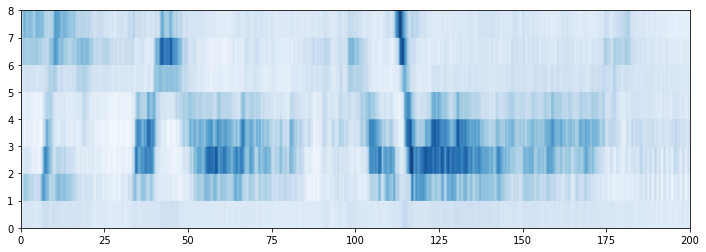

In [38]:
centroidPerm = [0,3,7,1,8,6,5,2,4]
centroids2Plot = centroids[centroidPerm,:]

fig, axs = plt.subplots(1,1,figsize=(12,4))

axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')
fig.savefig(saveDir+sep+'_'.join(['ROIcluster_kn{}_DFFreordered'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')